In [1]:
%matplotlib inline

import os
from time import time
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, log_loss
from scipy.stats import randint as sp_randint
from scipy import interp
from drivendata_validator import DrivenDataValidator

import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

## PLOT PROPERTIES
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams["savefig.facecolor"] = '#ffffff'
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False

# data directory
DATA_DIR = os.path.join('..', 'data', 'processed')

In [2]:
# Standardize features
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtract by mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df
    
## Pre Process Data - Convert the Categoricals and Standardize Numbers
def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        

    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)
    
    return df

## Train a RandomForest Classifier
def train_model(features, labels, **kwargs):
    
    # instantiate model
    model = RandomForestClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print "In-sample accuracy: %0.2f"%(accuracy)
    
    return model

## Make Submission DataFrame
def make_country_sub(preds, test_feat, country):
    # make sure we code the country correctly
    country_codes = ['A', 'B', 'C']
    
    # get just the poor probabilities
    country_sub = pd.DataFrame(data=preds[:, 1],  # proba p=1
                               columns=['poor'], 
                               index=test_feat.index)

    
    # add the country code for joining later
    country_sub["country"] = country
    return country_sub[["country", "poor"]]

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

##### Household-level survey data: 
This is obfuscated data from surveys conducted by The World Bank, focusing on household-level statistics. The data come from three different countries, and are separated into different files for convenience.

##### Individual-level survey data: 
This is obfuscated data from related surveys conducted by The World Bank, only these focus on individual-level statistics. The set of interviewees and countries involved are the same as the household data, as indicated by shared id indices, but this data includes detailed (obfuscated) information about household members.

##### Submission format:
This gives us the filenames and columns of our submission prediction, filled with all 0.5 as a baseline.

In [3]:
## define data paths
data_paths = {'A': {'train': os.path.join(DATA_DIR, 'A', 'A_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'A', 'A_hhold_test.csv')}, 
              
              'B': {'train': os.path.join(DATA_DIR, 'B', 'B_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'B', 'B_hhold_test.csv')}, 
              
              'C': {'train': os.path.join(DATA_DIR, 'C', 'C_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'C', 'C_hhold_test.csv')}}

In [4]:
# load training data
a_train = pd.read_csv(data_paths['A']['train'], index_col='id')
b_train = pd.read_csv(data_paths['B']['train'], index_col='id')
c_train = pd.read_csv(data_paths['C']['train'], index_col='id')

# load test data
a_test = pd.read_csv(data_paths['A']['test'], index_col='id')
b_test = pd.read_csv(data_paths['B']['test'], index_col='id')
c_test = pd.read_csv(data_paths['C']['test'], index_col='id')

#### The first thing to notice is that each country's surveys have wildly different numbers of columns, so we'll plan on training separate models for each country and combining our predictions for submission at the end.

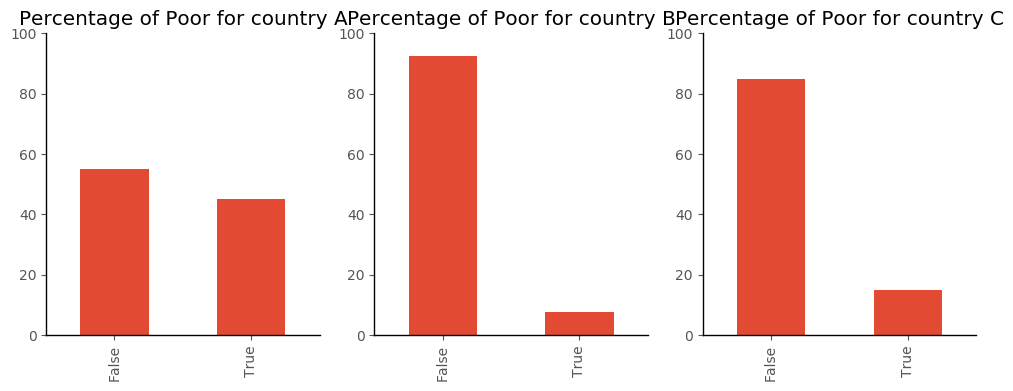

In [5]:
f, ax = plt.subplots(1, 3, figsize=(12,4), dpi=100, facecolor='w', edgecolor='k')
((a_train.poor.value_counts()/a_train.poor.shape[0])*100).plot.bar(title='Percentage of Poor for country A', ax=ax[0], ylim=(0, 100))
((b_train.poor.value_counts()/b_train.poor.shape[0])*100).plot.bar(title='Percentage of Poor for country B', ax=ax[1], ylim=(0, 100))
((c_train.poor.value_counts()/c_train.poor.shape[0])*100).plot.bar(title='Percentage of Poor for country C', ax=ax[2], ylim=(0, 100))
plt.show()

### Pre-process Data

In [6]:
print 'Preprocessing Training'
print("Country A")
aX_train = pre_process_data(a_train.drop('poor', axis=1))
ay_train = np.ravel(a_train.poor)

print("\nCountry B")
bX_train = pre_process_data(b_train.drop('poor', axis=1))
by_train = np.ravel(b_train.poor)

print("\nCountry C")
cX_train = pre_process_data(c_train.drop('poor', axis=1))
cy_train = np.ravel(c_train.poor)

print '\n\nPreprocessing Testing'
# process the test data
print("Country A")
a_test = pre_process_data(a_test, enforce_cols=aX_train.columns)

print("Country B")
b_test = pre_process_data(b_test, enforce_cols=bX_train.columns)

print("Country C")
c_test = pre_process_data(c_test, enforce_cols=cX_train.columns)

Training
Country A
Input shape:	(8203, 344)
After standardization (8203, 344)
After converting categoricals:	(8203, 859)

Country B
Input shape:	(3255, 441)
After standardization (3255, 441)
After converting categoricals:	(3255, 1432)

Country C
Input shape:	(6469, 163)
After standardization (6469, 163)
After converting categoricals:	(6469, 795)


Testing
Country A
Input shape:	(4041, 344)
After standardization (4041, 344)
After converting categoricals:	(4041, 851)
Country B
Input shape:	(1604, 441)
After standardization (1604, 441)
After converting categoricals:	(1604, 1419)
Country C
Input shape:	(3187, 163)
After standardization (3187, 163)
After converting categoricals:	(3187, 773)


In [7]:
## restructure train data
all_train_data = {'A': {'features': aX_train, 
                    'labels': ay_train},
                  'B': {'features': bX_train,
                        'labels':  by_train}, 
                  'C': {'features': cX_train, 
                        'labels':  cy_train}}

## restructure test data
all_test_data = {'A': {'features': a_test},
                 'B': {'features': b_test},
                 'C': {'features': c_test}}

### Cross-validation - Tune Parameters

In [8]:
tune_params = 1
if tune_params > 0:
    bestParams = []
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.6, random_state=0)
    for grp in all_train_data:
        
        print 'Working on group : %s'%(grp)
        
        # get some data
        X = all_train_data[grp]['features'].values.astype(np.float32)
        y = all_train_data[grp]['labels'].astype(np.int16)

        # build a classifier
        clf = RandomForestClassifier()

        # specify parameters and distributions to sample from
        param_dist = {"n_estimators": sp_randint(1, 1000),
                      "max_depth": sp_randint(3, 303),
                      "max_features": sp_randint(1, 350),
                      "min_samples_split": sp_randint(2, 350),
                      "min_samples_leaf": sp_randint(1, 350),
                      "bootstrap": [True, False],
                      "criterion": ["gini", "entropy"]}

        # run randomized search
        n_iter_search = 5000
        random_search = RandomizedSearchCV(clf, scoring='neg_log_loss', 
                                           param_distributions=param_dist, 
                                           n_iter=n_iter_search, cv=cv,
                                          return_train_score=False)

        start = time()
        random_search.fit(X, y)
        gridSearchScores = pd.DataFrame(random_search.cv_results_)
        gridSearchScores.sort_values(['mean_test_score'], axis=0, ascending=False, inplace=True)
        gridSearchScores.head()

        all_train_data[grp]['best_parameters'] = gridSearchScores.iloc[0,:]
        bestParams.append(all_train_data[grp]['best_parameters'])

    bestParamsDF = pd.DataFrame(bestParams, index=['A', 'B', 'C'])
    bestParamsDF.to_csv('bestParametersAllThreeModels.txt', sep='\t', index_label='group')
    print bestParamsDF
else:
    print 'Using the previously optimized parameters......'
    bestParamsDF = pd.read_csv('bestParametersAllThreeModels.txt', sep='\t', index_col='group')

Using the previously optimized parameters......


### Training Phase

In [9]:
## Train Model
trained_models = {}
for grp in all_train_data:
    trained_models[grp] = RandomForestClassifier(bootstrap=bestParamsDF.loc[grp, 'param_bootstrap'],
                                     min_samples_leaf=bestParamsDF.loc[grp, 'param_min_samples_leaf'],
                                     n_estimators=bestParamsDF.loc[grp, 'param_n_estimators'], 
                                     min_samples_split=bestParamsDF.loc[grp, 'param_min_samples_split'],
                                     criterion=bestParamsDF.loc[grp, 'param_criterion'],
                                     max_features=bestParamsDF.loc[grp, 'param_max_features'],
                                     max_depth=bestParamsDF.loc[grp, 'param_max_depth'])
    trained_models[grp].fit(all_train_data[grp]['features'], all_train_data[grp]['labels'])

### Testing Phase

In [10]:
## Predict
predictions = {}
for grp in all_train_data:
    predictions[grp] = trained_models[grp].predict_proba(all_test_data[grp]['features'])

### Validate and Submit

In [12]:
# convert preds to data frames
predictionsDF = {}
for grp in all_train_data:
    predictionsDF[grp] = make_country_sub(predictions[grp], all_test_data[grp]['features'], grp)

submission = []
submission = pd.concat([predictionsDF['A'], predictionsDF['B'], predictionsDF['C']])

## Submission Format
submission.to_csv('../data/my_submission.csv')

# no parameters unless we have a read_csv kwargs file
v = DrivenDataValidator()

if v.is_valid('../data/submission_format.csv', '../data/my_submission.csv'):
    print "I am awesome."
else:
    print "I am not so cool."


I am awesome.
